In [1]:
import fastai
from fastai.vision.all import *
from icevision.models import *
from icevision.all import *
from mmcv.runner import (
    load_checkpoint,
    save_checkpoint,
    _load_checkpoint,
    load_state_dict,
)
import cv2
import imagesize
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Rectangle
import json

pd.set_option('display.max_columns',1000)
pd.set_option('display.max_rows',1000)
pd.set_option('display.width',1000)

In [2]:
df = pd.read_csv("train-annotations.csv", low_memory = False)

In [3]:
df.head()

,Image,bbox,width,height,xmin,ymin,xmax,ymax,label
0,0000e88ab.jpg,"[(234.0, 161.0), (860.0, 441.0)]",1050,700,234.0,161.0,860.0,441.0,whale
1,00029d126.jpg,"[(9.0, 87.0), (740.0, 259.0)]",1050,497,9.0,87.0,740.0,259.0,whale
2,00050a15a.jpg,"[(27.0, 198.0), (1030.0, 370.0)]",1050,525,27.0,198.0,1030.0,370.0,whale
3,0005c1ef8.jpg,"[(22.0, 158.0), (1009.0, 329.0)]",1050,525,22.0,158.0,1009.0,329.0,whale
4,0006e997e.jpg,"[(25.0, 31.0), (956.0, 252.0)]",980,276,25.0,31.0,956.0,252.0,whale


In [4]:
## create parser
template_record = ObjectDetectionRecord()

In [5]:
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_img_size(<ImgSize>)
        record.set_filepath(<Union[str, Path]>)
        record.detection.add_bboxes(<Sequence[BBox]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)


In [6]:
class WhaleParser(Parser):
    def __init__(self, template_record, data_dir):
        super().__init__(template_record = template_record)
        self.data_dir = data_dir
        self.df = pd.read_csv("/home/fluke/train-annotations.csv")
        self.class_map = ClassMap(list(self.df["label"].unique()))
        
    def __iter__(self) -> Any :
        for o in self.df.itertuples():
            yield o
    
    def __len__(self) -> int :
        return (len(self.df))
    
    def record_id(self, o) -> Hashable :
        return o.Image
    
    def parse_fields(self, o, record, is_new):
        if is_new :
            record.set_filepath(self.data_dir / o.Image)
            record.set_img_size(ImgSize(width = o.width, height = o.height))
            record.detection.set_class_map(self.class_map)
        
        record.detection.add_bboxes([BBox.from_xyxy(o.xmin, o.ymin, o.xmax, o.ymax)])
        record.detection.add_labels([o.label])

In [7]:
data_dir = Path.cwd()
print (data_dir)
parser = WhaleParser(template_record, data_dir)

/home/fluke


In [11]:
train_records, valid_records = parser.parse()

INFO     - Autofixing records | icevision.parsers.parser:parse:122


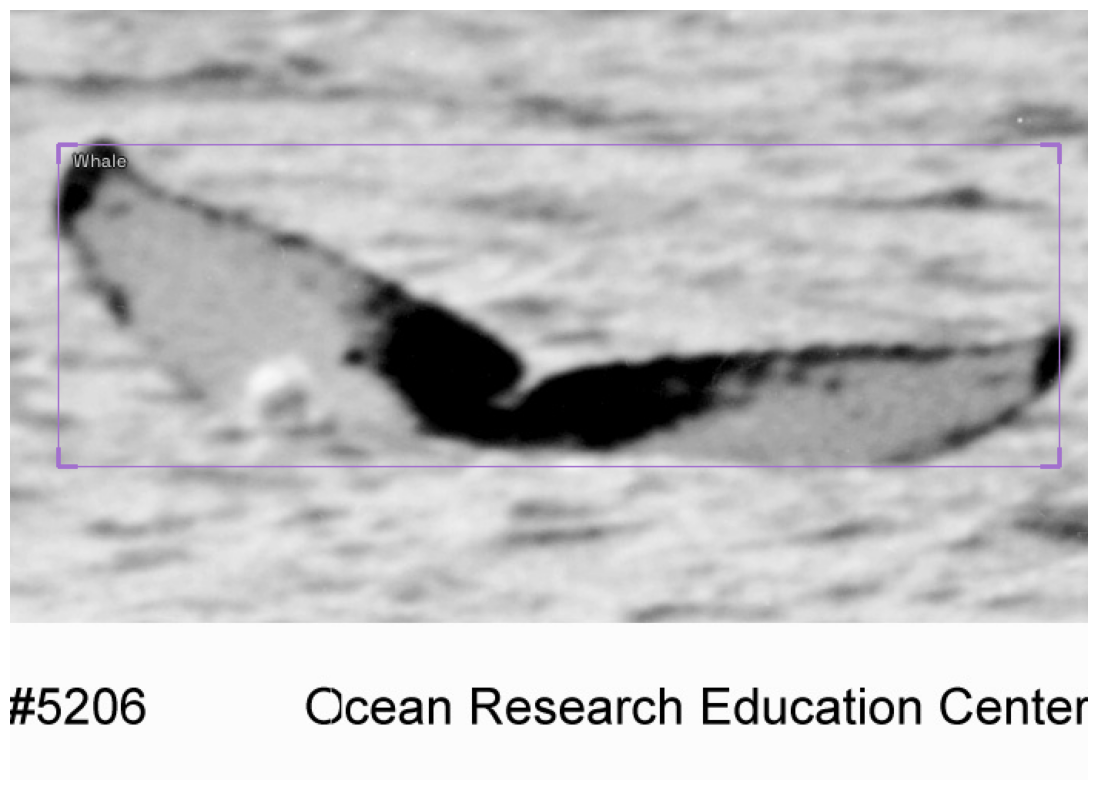

In [13]:
show_record(train_records[2], display_label = True, figsize = (14, 10))

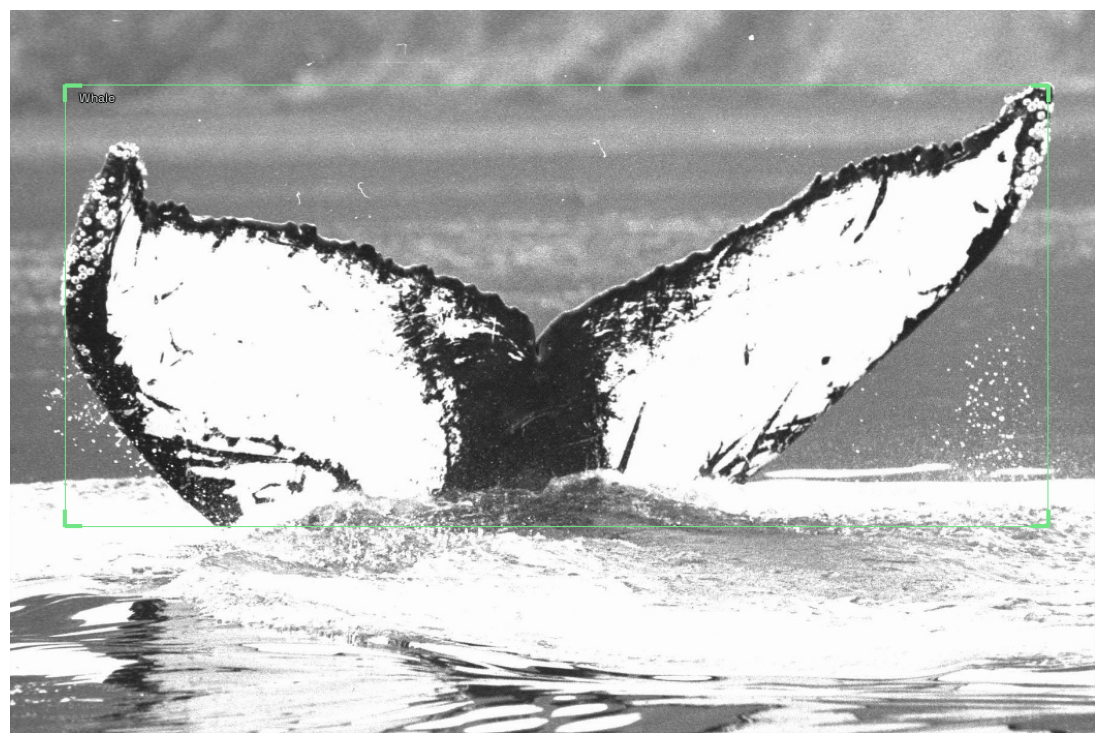

In [14]:
show_record(valid_records[1], display_label = True, figsize = (14, 10))

In [15]:
len(train_records), len(valid_records)

(800, 200)

In [16]:
## Transformations
image_size = 384
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size = image_size, presize = 512), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size = image_size), tfms.A.Normalize()])

In [17]:
## Datasets
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)

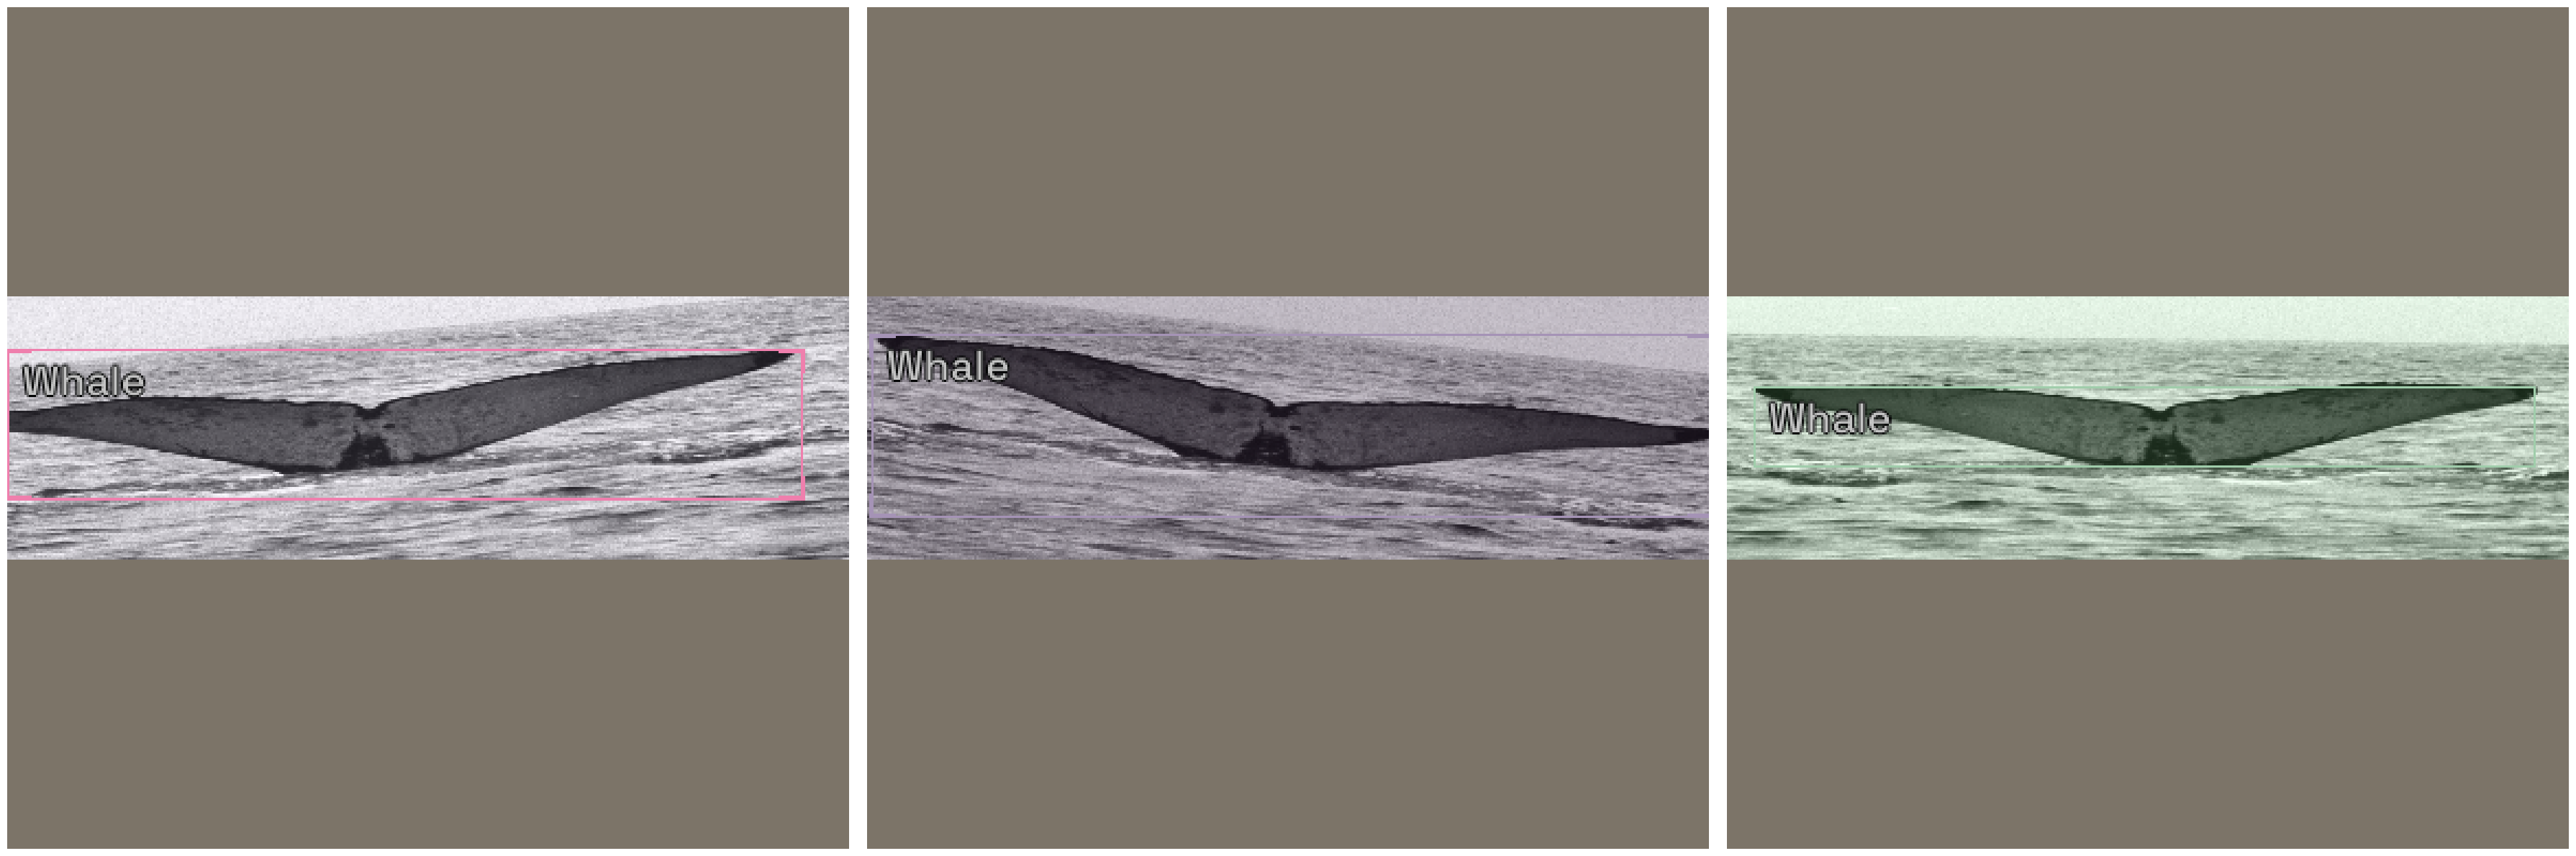

In [18]:
## show some samples
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols = 3)

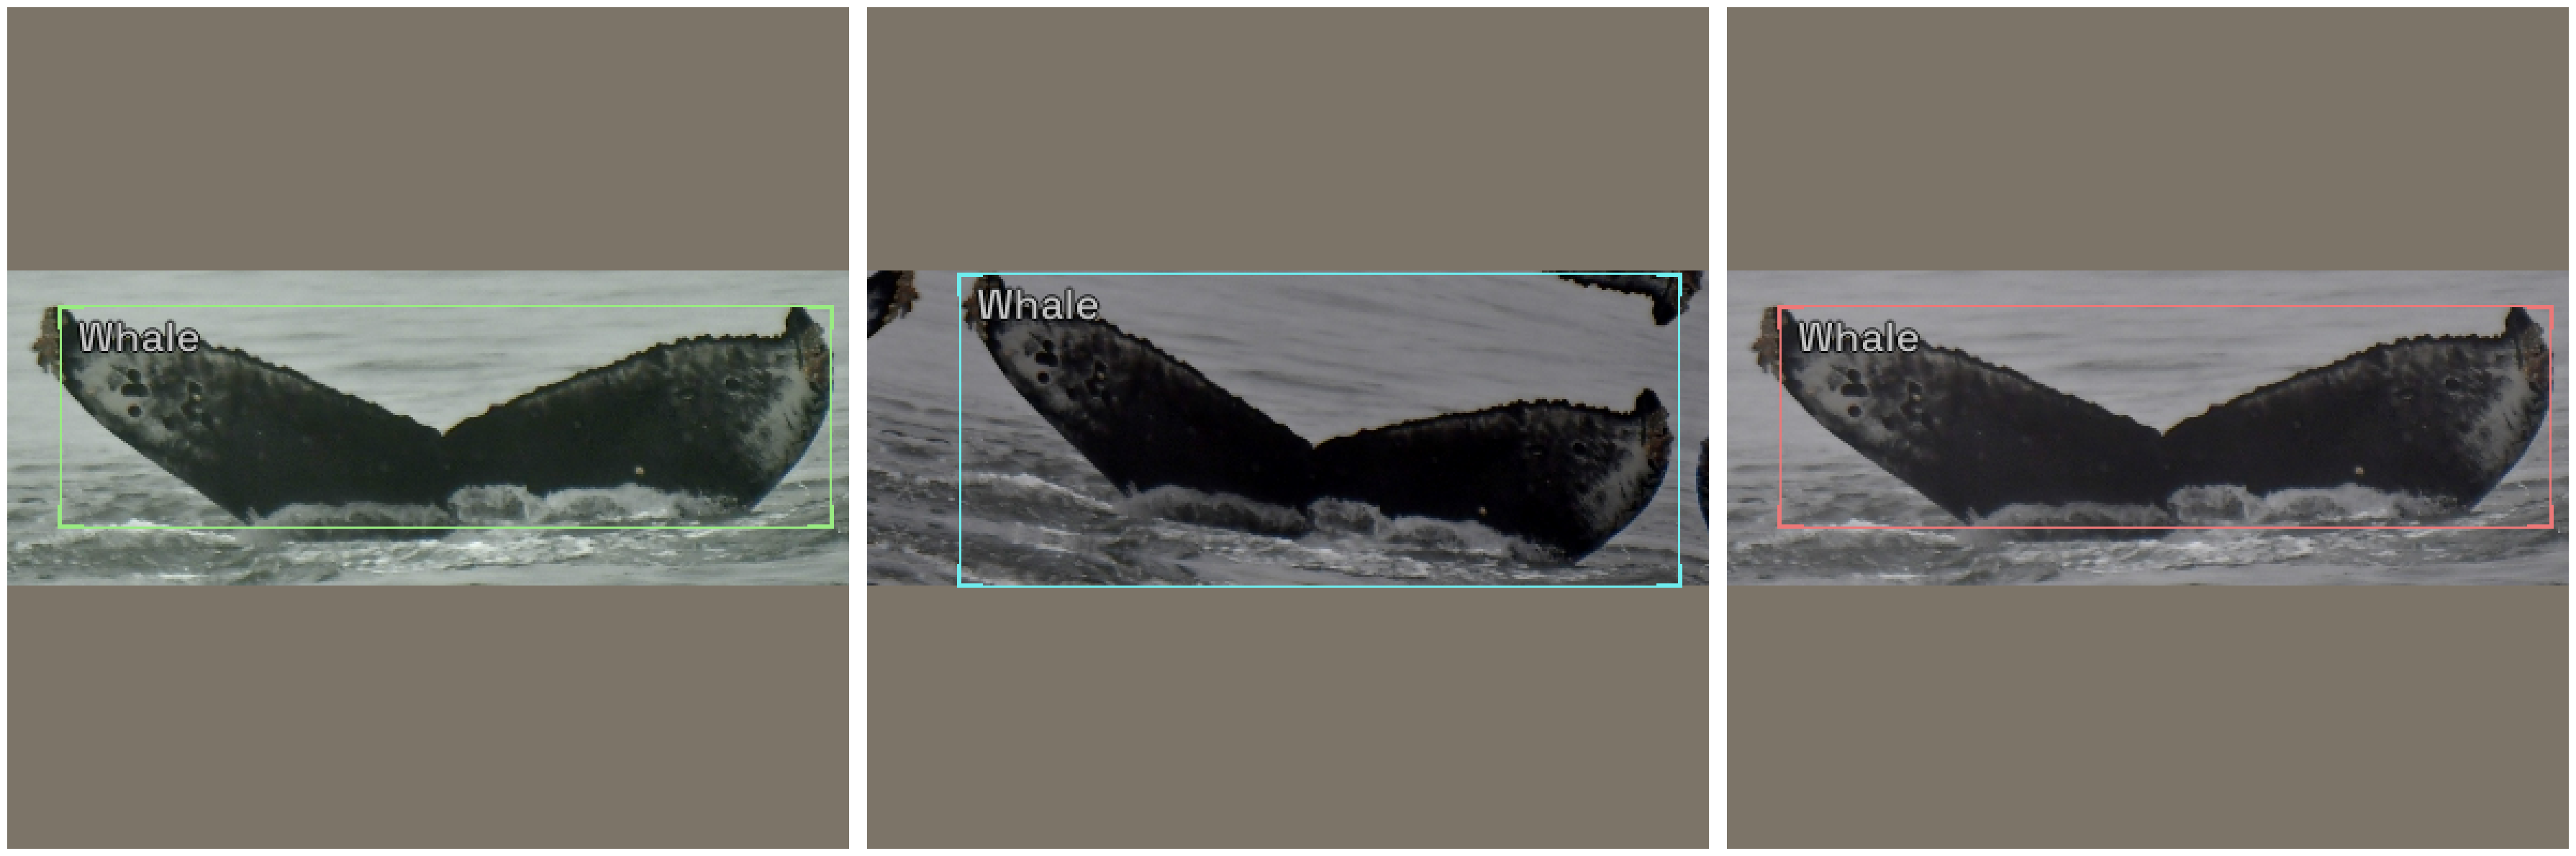

In [19]:
## show some samples
samples = [train_ds[11] for _ in range(3)]
show_samples(samples, ncols = 3)

In [20]:
## model definition
extra_args = {}
model_type = models.ultralytics.yolov5
backbone = model_type.backbones.small
extra_args['img_size'] = image_size

In [22]:
## instantiate the model
model = model_type.model(backbone = backbone(pretrained = True), num_classes = len(parser.class_map), **extra_args)

02/15/2022 05:00:29 - INFO - yolov5.models.yolo -   Overriding model.yaml nc=80 with nc=1
02/15/2022 05:00:29 - INFO - yolov5.models.yolo -   
                 from  n    params  module                                  arguments                     
02/15/2022 05:00:29 - INFO - yolov5.models.yolo -     0                -1  1      3520  yolov5.models.common.Conv               [3, 32, 6, 2, 2]              
02/15/2022 05:00:29 - INFO - yolov5.models.yolo -     1                -1  1     18560  yolov5.models.common.Conv               [32, 64, 3, 2]                
02/15/2022 05:00:29 - INFO - yolov5.models.yolo -     2                -1  1     18816  yolov5.models.common.C3                 [64, 64, 1]                   
02/15/2022 05:00:29 - INFO - yolov5.models.yolo -     3                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
02/15/2022 05:00:29 - INFO - yolov5.models.yolo -     4                -1  2    115712  yolov5.models.common.C3   

In [23]:
## Dataloaders
train_dl = model_type.train_dl(train_ds, batch_size = 16, num_workers = 4, shuffle = True)
valid_dl = model_type.valid_dl(valid_ds, batch_size = 16, num_workers = 4, shuffle = False)

In [24]:
metrics = [COCOMetric(metric_type = COCOMetricType.bbox)]

In [25]:
## training using fastai
learn = model_type.fastai.learner(dls = [train_dl, valid_dl], model = model, metrics = metrics)

/opt/conda/lib/python3.8/site-packages/fastai/callback/schedule.py:269: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


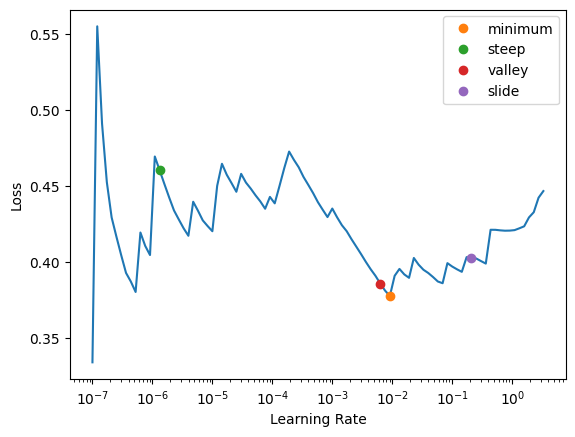

In [26]:
## find learning rate
lrs = learn.lr_find(suggest_funcs = (minimum, steep, valley, slide))

In [27]:
lrs.minimum

0.0009120108559727668

In [28]:
learn.fit_one_cycle(25, lrs.minimum / 10)

epoch,train_loss,valid_loss,COCOMetric,time
0,0.418952,0.381491,0.000439,00:10
1,0.379663,0.390335,0.000489,00:10
2,0.381215,0.411281,0.003434,00:10
3,0.362091,0.287934,0.018374,00:09
4,0.334429,0.290504,0.060392,00:09
5,0.299675,0.269614,0.078854,00:09
6,0.285696,0.242728,0.174032,00:09
7,0.265811,0.221494,0.142159,00:09
8,0.247484,0.233800,0.200512,00:09
9,0.243027,0.273346,0.218846,00:09


In [29]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-4, 1e-2))

epoch,train_loss,valid_loss,COCOMetric,time
0,0.188588,0.266360,0.398259,00:10
1,0.194149,0.246401,0.408908,00:09
2,0.199629,0.227267,0.534081,00:09
3,0.202693,0.185489,0.594202,00:09
4,0.195514,0.163259,0.552395,00:09
5,0.170075,0.117147,0.679318,00:09
6,0.136050,0.096917,0.737771,00:09
7,0.132385,0.105209,0.699999,00:09
8,0.116519,0.098327,0.737294,00:09
9,0.111589,0.096637,0.848162,00:09


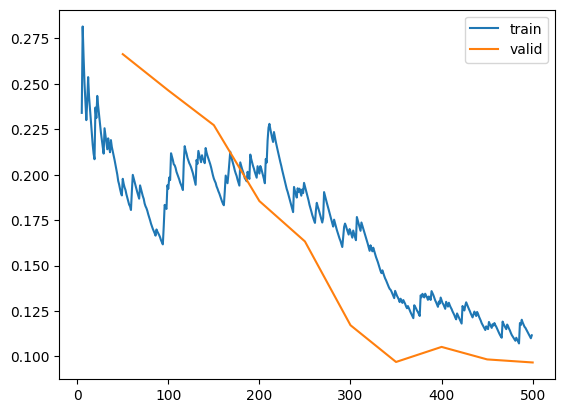

In [30]:
learn.recorder.plot_loss()

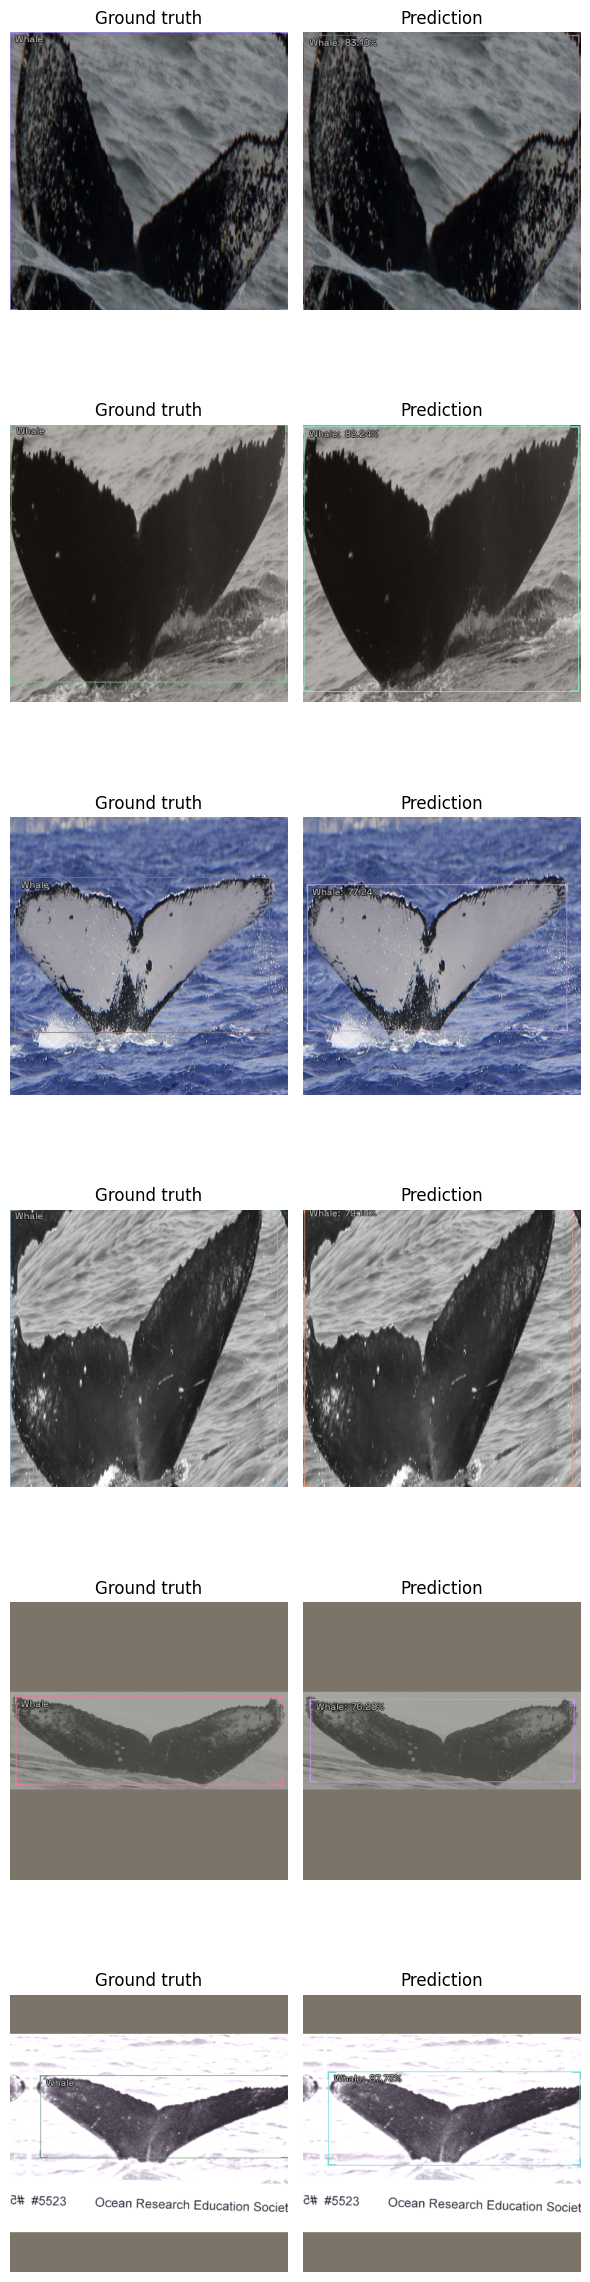

In [31]:
model_type.show_results(model, valid_ds, detection_threshold = 0.25)